#  Optimization for Machine Learning – Homework Part 2  
## Étude expérimentale du pas optimal et loi d’échelle

###  Objectif
L’objectif est d’étudier comment le **pas d’apprentissage optimal (α\*)** varie avec la **taille cachée (d)** d’un réseau de neurones à une couche ReLU.  
Le projet comporte deux étapes :
1. Déterminer expérimentalement le meilleur pas α\*(d=16).  
2. Étudier comment ce pas évolue selon d et ajuster une loi d’échelle α\*(d) ≈ ν·d^γ.

Ce travail met en œuvre :
- la **descente de gradient full-batch à pas constant**,  
- une **sélection au meilleur hyperparamètre** (perte validation finale),  
- et le **comptage des appels gradient** comme unité de coût.


In [14]:
#Configuration

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple
from scipy.stats import linregress

# Seeds pour reproductibilité (critères de benchmarking)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Configuration: float32, CPU
torch.set_default_dtype(torch.float32)
device = torch.device('cpu')


### Données

On génère n = 200 points (tᵢ, yᵢ)ᵢ₌₁ⁿ selon le modèle :

$$y_i = \sin(t_i) + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, 0.01)$$

où $t_i \sim \mathcal{U}([-5, 5])$.

Les données sont mélangées aléatoirement puis partitionnées en :
- **Ensemble d'entraînement** : 80% des observations
- **Ensemble de validation** : 20% des observations

Cette séparation permet d'éviter l'overfitting.

In [15]:
# Paramètres de génération
n = 200
T = 5.0
sigma = 0.1
train_ratio = 0.8

# Génération des données
t = np.linspace(-T, T, n)
epsilon = np.random.normal(0, sigma, n)
y = np.sin(t) + epsilon

# Mélange aléatoire puis split train/validation
indices = np.random.permutation(n)
n_train = int(n * train_ratio)
train_indices = indices[:n_train]
val_indices = indices[n_train:]

# Conversion en tenseurs PyTorch (float32)
t_train = torch.tensor(t[train_indices], dtype=torch.float32).reshape(-1, 1)
y_train = torch.tensor(y[train_indices], dtype=torch.float32).reshape(-1, 1)
t_val = torch.tensor(t[val_indices], dtype=torch.float32).reshape(-1, 1)
y_val = torch.tensor(y[val_indices], dtype=torch.float32).reshape(-1, 1)


### Modèle

Le réseau étudié est un **perceptron multicouche (MLP) à une couche cachée** avec activation ReLU :

$$h_\theta(t) = \mathbf{w}_2^\top \cdot \text{ReLU}(\mathbf{w}_1 t + \mathbf{b}_1) + b_2$$

où $\mathbf{w}_1, \mathbf{b}_1 \in \mathbb{R}^d$, $\mathbf{w}_2 \in \mathbb{R}^d$ et $b_2 \in \mathbb{R}$.

Le paramètre $d$ (dimension de la couche cachée) sera varié lors des expériences.

**Initialisation des poids** : Nous utilisons l'initialisation de **He** , conçue pour les réseaux avec activations ReLU. Cette méthode initialise les poids selon :

$$w_{ij} \sim \mathcal{N}\left(0, \frac{2}{n_{\text{in}}}\right)$$

où $n_{\text{in}}$ désigne le nombre de neurones en entrée. Le facteur 2 compense l'annulation d'environ la moitié des activations par la fonction ReLU, assurant ainsi la stabilité de la variance des activations à travers les couches et permettant un **apprentissage plus stable et plus rapide**.

In [16]:
#Modèle

class SingleHiddenLayerNet(torch.nn.Module):
    """
    Réseau à une couche cachée avec activation ReLU.
    """
    def __init__(self, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(1, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        
        # Initialisation He pour ReLU 
        torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(self.fc1.bias)
        torch.nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        torch.nn.init.zeros_(self.fc2.bias)
    
    def forward(self, t):
        hidden = torch.relu(self.fc1(t))  # ReLU(w1*t + b1)
        output = self.fc2(hidden)          # w2^T * hidden + b2
        return output
    


## Fonction d'entraînement

L'optimisation est effectuée par **descente de gradient à pas constant en régime full-batch** :

$$\theta_{k+1} = \theta_k - \alpha \nabla \mathcal{L}(\theta_k)$$

où :
- $\mathcal{L}(\theta)$ est l'erreur quadratique moyenne (MSE) sur l'ensemble d'entraînement
- $\alpha$  est le pas d'apprentissage (learning rate)
- $\nabla \mathcal{L}(\theta_k)$ est le gradient calculé sur l'intégralité des données d'entraînement

**Protocole expérimental** :
- Calcul des pertes train et validation à chaque itération
- Budget d'itérations $T$ fixe et identique pour toutes les configurations


In [17]:
#Fonction train
def train_one_run(model, alpha, T, t_train, y_train, t_val, y_val, verbose=False):
    """
    Entraîne le modèle avec Gradient Descent full-batch à pas constant.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha, momentum=0.0)
    criterion = torch.nn.MSELoss()
    
    history = {
        'loss_train': [],
        'loss_val': [],
        'iterations': [],
        'status': 'OK'
    }
    
    # Boucle d'entraînement
    for k in range(T):
        y_pred_train = model(t_train)
        loss_train = criterion(y_pred_train, y_train)
        
        optimizer.zero_grad() 
        loss_train.backward()  
        
        # Vérification de stabilité (NaN/Inf)
        if torch.isnan(loss_train) or torch.isinf(loss_train):
            history['status'] = 'instable'
            if verbose:
                print(f"  Divergence détectée à l'itération {k}")
            break
        optimizer.step()
        
        #Évaluation (inutile de stocker les gradients)
        with torch.no_grad():
            # Perte validation
            y_pred_val = model(t_val)
            loss_val = criterion(y_pred_val, y_val)
            
            history['loss_train'].append(loss_train.item())
            history['loss_val'].append(loss_val.item())
            history['iterations'].append(k)
        
        if verbose and (k % 200 == 0 or k == T-1):
            print(f"  Iter {k:4d}: Train Loss = {loss_train.item():.6f}, Val Loss = {loss_val.item():.6f}")
    
    return history


In [18]:
#Fonction d'évaluation
def evaluate_alpha(d, alpha, T, t_train, y_train, t_val, y_val, seed, verbose=False):
    """
    Évalue un pas d'apprentissage α pour une taille de couche cachée d.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    model = SingleHiddenLayerNet(d)
    
    if verbose:
        print(f"Entraînement avec d={d}, α={alpha:.2e}, T={T}")
    
    history = train_one_run(model, alpha, T, t_train, y_train, t_val, y_val, verbose=verbose)
    
    # Extraction des résultats finaux
    if history['status'] == 'OK' and len(history['loss_train']) > 0:
        loss_train_final = history['loss_train'][-1]
        loss_val_final = history['loss_val'][-1]
    else:
        # Si divergence, on met des valeurs infinies
        loss_train_final = float('inf')
        loss_val_final = float('inf')
    
    return loss_train_final, loss_val_final, history['status'], history

## Question 1 – Recherche du pas optimal pour d = 16

### Méthodologie
- Grille de pas testés à echelle logarithmique
- Budget fixe T = 3000 itérations pour toutes les valeurs  
- Sélection “au meilleur hyperparamètre” (validation finale)  
- Marquage “instable” pour toute divergence (NaN, perte croissante, explosion)


In [19]:
#Trouver le pas optimal 

def find_best_alpha_for_d(d, alpha_grid, T, t_train, y_train, t_val, y_val, seed):
    """
    Trouve le pas celon la grille donnée
    """
    results_d = []
    
    for alpha in alpha_grid:
        loss_train, loss_val, status, history = evaluate_alpha(
            d, alpha, T, t_train, y_train, t_val, y_val, seed, verbose=False
        )
        
        results_d.append({
            'd': d,
            'alpha': alpha,
            'loss_train_final': loss_train,
            'loss_val_final': loss_val,
            'status': status,
            'n_iterations': T if status == 'OK' else len(history['loss_train']),
            'history': history
        })

    
    # Sélection du meilleur α
    df_d = pd.DataFrame([{
        'alpha': r['alpha'], 'loss_val_final': r['loss_val_final'], 'status': r['status']
    } for r in results_d])
    
    df_stable = df_d[df_d['status'] == 'OK']
    if len(df_stable) > 0:
        idx_best = df_stable['loss_val_final'].idxmin()
        best_alpha = df_stable.loc[idx_best, 'alpha']
        best_val_loss = df_stable.loc[idx_best, 'loss_val_final']
    else:
        best_alpha = None
        best_val_loss = float('inf')
    
    return results_d, best_alpha, best_val_loss, df_d


d_init = 16
T_budget = 3000
alpha_grid_d16 = np.logspace(-2.1, -1.5, 18)

results_d16, best_alpha_d16, val_loss_d16, df_d16 = find_best_alpha_for_d(
    d_init, alpha_grid_d16, T_budget, t_train, y_train, t_val, y_val, SEED
)

print(f"\nMeilleur α pour d={d_init}: {best_alpha_d16:.4e} (Val Loss: {val_loss_d16:.6f})\n")


Meilleur α pour d=16: 2.2847e-02 (Val Loss: 0.014156)



### Courbes d’apprentissage pour d = 16

Pour visualiser la vitesse de convergence des différents pas, on trace les courbes d’apprentissage montrant l’évolution de la perte d’entraînement et de validation au fil des itérations.  
Ces courbes permettent d’observer la vitesse de convergence et la stabilité selon le pas d’apprentissage choisi.  
Elles aident à identifier le pas optimal α*, celui qui réduit la perte rapidement sans provoquer d’instabilité ni de stagnation prématurée.

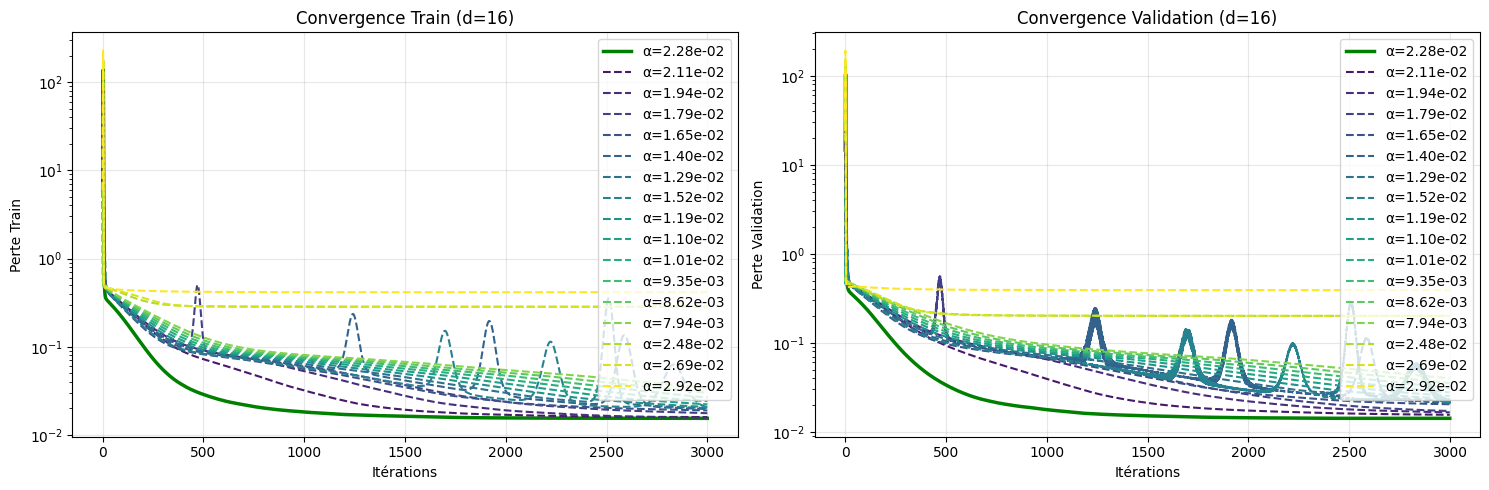

In [20]:
#Plot de Convergence

df_stable = df_d16[df_d16['status'] == 'OK'].sort_values('loss_val_final')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
results_dict = {r['alpha']: r for r in results_d16}
colors = plt.cm.viridis(np.linspace(0, 1, len(df_stable)))

for i, (_, row) in enumerate(df_stable.iterrows()):
    alpha_val = row['alpha']
    history = results_dict[alpha_val]['history']
    is_best = (alpha_val == best_alpha_d16)
    label = f"α={alpha_val:.2e}" 
    style = '-' if is_best else '--'
    width = 2.5 if is_best else 1.5
    color = 'green' if is_best else colors[i]
    
    ax1.semilogy(history['iterations'], history['loss_train'], 
                label=label, linestyle=style, linewidth=width, color=color)
    ax2.semilogy(history['iterations'], history['loss_val'], 
                label=label, linestyle=style, linewidth=width, color=color)

ax1.set_xlabel('Itérations')
ax1.set_ylabel('Perte Train')
ax1.set_title(f'Convergence Train (d={d_init})')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Itérations')
ax2.set_ylabel('Perte Validation')
ax2.set_title(f'Convergence Validation (d={d_init})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interprétation

Ces résultats vérifient les propriétés théoriques de la descente de gradient :

- Un **pas trop petit** conduit à une convergence lente (O(1/k))
- Un **pas trop grand** viole la condition de stabilité α < 2/L
- Un **pas intermédiaire** proche de 1/L maximise la vitesse de descente

Le meilleur pas obtenu est :

$\alpha^*(d = 16) = 2.2847 \times 10^{-2}$


### Vérification du modéle avec le pas optimal

Après avoir identifié le pas d'apprentissage optimal $\alpha^*  $ pour $d = 16$, nous entraînons le modèle avec ces hyperparamètres et visualisons ses prédictions.En comparant les predictions du modèle avec la fonction cible

Le graphique suivant compare:
- La **fonction cible** $y = \sin(t)$ (ligne noire pointillée)
- Les **prédictions du modèle** $h_{\theta^*}(t)$ (courbe rouge)
- Les **données d'entraînement** (points bleus) et de **validation** (points orange)

On constate que la fonction cible est globalement bien prédite, à l’exception des deux extrémités où l’erreur est plus marquée.

Cette visualisation permet d'évaluer qualitativement la **capacité d'approximation** du réseau et de détecter d'éventuels problèmes de sous-apprentissage ou de sur-apprentissage.

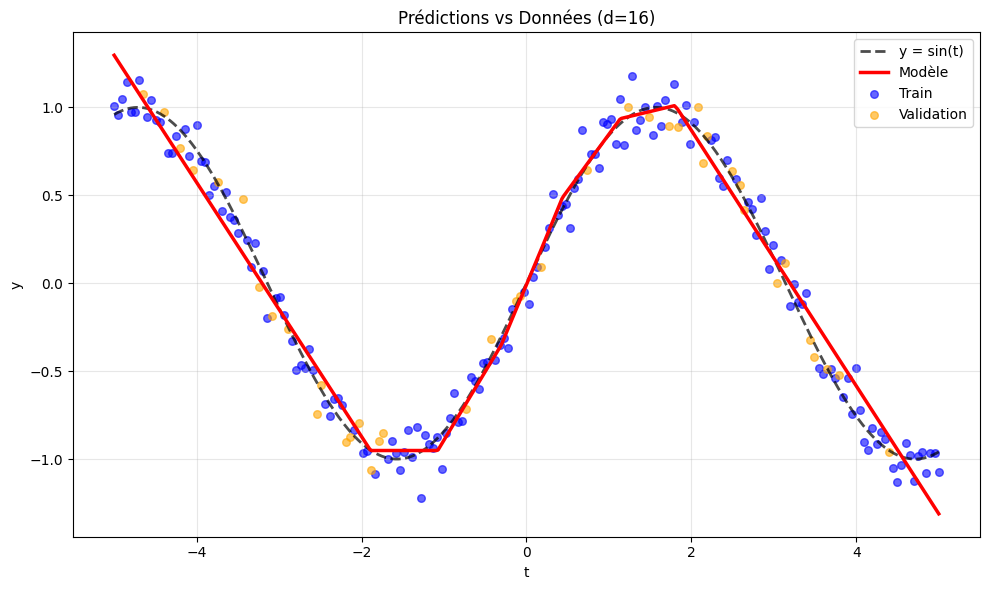

In [21]:
#Plot Prédiction vs Données

model_best = SingleHiddenLayerNet(d_init)
train_one_run(model_best, best_alpha_d16, T_budget, t_train, y_train, t_val, y_val)

model_best.eval()
with torch.no_grad():
    t_plot = torch.linspace(-5, 5, 500).reshape(-1, 1)
    y_pred = model_best(t_plot)

plt.figure(figsize=(10, 6))
plt.plot(t_plot.numpy(), np.sin(t_plot.numpy()), 'k--', linewidth=2, label='y = sin(t)', alpha=0.7)
plt.plot(t_plot.numpy(), y_pred.numpy(), 'r-', linewidth=2.5, label='Modèle')
plt.scatter(t_train.numpy(), y_train.numpy(), s=30, alpha=0.6, color='blue', label='Train')
plt.scatter(t_val.numpy(), y_val.numpy(), s=30, alpha=0.6, color='orange', label='Validation')
plt.xlabel('t')
plt.ylabel('y')
plt.title(f'Prédictions vs Données (d={d_init})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Question 2 : Loi d'échelle du pas optimal α*(d)

### Objectif

Étudier empiriquement **l'évolution du pas d'apprentissage optimal** $\alpha^*(d)$ en fonction de la dimension de la couche cachée $d$.

On cherche à déterminer une **loi de puissance** de la forme :

$$\boxed{\alpha^*(d) \approx \nu \, d^{\gamma}}$$

où :
- $\alpha^*(d)$ : pas optimal minimisant la perte de validation pour une dimension $d$
- $\nu $ : coefficient de proportionnalité
- $\gamma$ : exposant caractérisant la dépendance en $d$

---

### Méthodologie

**2. Expérimentation multi-échelles**

Nous savons que :

- Si $d$ augmente, le modèle devient plus grand → les gradients sont souvent plus instables, donc il faut un $\alpha$ plus petit pour rester stable.

- Si $d$ diminue, le modèle est plus petit → on peut se permettre un $\alpha$ plus grand (il apprend plus vite sans exploser).

**2.1 Grille Adaptative**

Au lieu d'essayer manuellement une grille pour chaque dimension, on peut trouver une **grille adaptative** pour chaque $d$ grâce au pas optimal déjà trouvé en amont.

Suite au pas optimal trouvé précédemment pour $d=16$, on va l'utiliser comme **point d'ancrage** pour trouver une grille adaptive pour chaque dimension.

**Comment procéder ?**

Nous savons que la norme d'un vecteur de dimension $d$ augmente comme la racine carrée de $d$ :

$$
\|\nabla f\| \propto \sqrt{d}
$$

De plus, nous souhaitons garder une **taille de pas constante** d'une dimension à l'autre, sinon les pas deviennent trop grands (instables) ou trop petits (apprentissage trop lent) :

$$
\alpha \, \|\nabla f\| \approx \text{constant}
$$

**En combinant les deux :** Si on a $\|\nabla f\| \propto \sqrt{d}$ et qu'on veut $\alpha \, \|\nabla f\| \approx \text{constant}$, alors :

$$
\alpha(d) \propto \frac{1}{\sqrt{d}}
$$

On peut donc écrire :

$$
\frac{\alpha(d)}{\alpha(16)} \approx \left(\frac{16}{d}\right)^{0.5}
$$

**On en conclut que :**

$$
\boxed{\alpha(d) \approx \alpha(16) \left(\frac{16}{d}\right)^{0.5}}
$$

**3. Estimation de la loi de puissance**

Les couples $(d, \alpha^*(d))$ sont analysés en échelle **log-log**. En posant :

 $$\log \alpha^*(d) = \log \nu + \gamma \log d$$

on obtient par régression linéaire les paramètres $\gamma$ et $\nu$


In [22]:
# Recherche du Meilleur α pour Chaque d avec grille adaptative

d_values = [4, 8, 12, 16, 24, 32, 48, 64, 98]
T_budget_scaling = 1500

all_results = []
best_alphas = {}

for d in d_values:
    if d == 16:
        results_d = results_d16
        best_alpha = best_alpha_d16
        val_loss = val_loss_d16
    else:
        # Grille adaptative 
        alpha_predicted = best_alpha_d16 * np.sqrt(16 / d)
        alpha_grid = np.logspace(
            np.log10(alpha_predicted/5), 
            np.log10(alpha_predicted*5), 
            10
        )
        
        results_d, best_alpha, val_loss, df_d = find_best_alpha_for_d(
            d, alpha_grid, T_budget_scaling, t_train, y_train, t_val, y_val, SEED
        )
    
    all_results.extend(results_d)
    if best_alpha is not None:
        best_alphas[d] = (best_alpha, val_loss)

In [23]:
# Création du DataFrame récapitulatif
df_best_alphas = pd.DataFrame([
    {'d': d, 'alpha_star': alpha, 'val_loss': val_loss}
    for d, (alpha, val_loss) in best_alphas.items()
]).sort_values('d')

print("\nTableau récapitulatif: Meilleur α* trouvé pour chaque d")
print(df_best_alphas.to_string(index=False))


Tableau récapitulatif: Meilleur α* trouvé pour chaque d
 d  alpha_star  val_loss
 4    0.038211  0.200070
 8    0.027019  0.014516
12    0.015428  0.027677
16    0.022847  0.014156
24    0.015600  0.022921
32    0.013510  0.024282
48    0.007714  0.024296
64    0.004672  0.137615
98    0.003775  0.110443


In [24]:
#Régression logistique

d_array = df_best_alphas['d'].values
alpha_array = df_best_alphas['alpha_star'].values

# Passage en log-log
log_d = np.log(d_array)
log_alpha = np.log(alpha_array)

# Régression linéaire: log(α) = log(ν) + γ * log(d)
slope, intercept, r_value, p_value, std_err = linregress(log_d, log_alpha)

# Extraction de ν et γ
gamma = slope
nu = np.exp(intercept)


print(f"  ν = {nu:.6f}")
print(f"  γ = {gamma:.6f}")
print(f"\nQualité de l'ajustement:")
print(f"  R² = {r_value**2:.6f}")
print(f"  p-value = {p_value:.2e}")

# Calcul des prédictions
alpha_pred = nu * d_array ** gamma
df_best_alphas['alpha_pred'] = alpha_pred
df_best_alphas['relative_error'] = np.abs(alpha_array - alpha_pred) / alpha_array * 100

print("\nTableau avec prédictions:")
print(df_best_alphas.to_string(index=False))

  ν = 0.123543
  γ = -0.724784

Qualité de l'ajustement:
  R² = 0.908590
  p-value = 6.97e-05

Tableau avec prédictions:
 d  alpha_star  val_loss  alpha_pred  relative_error
 4    0.038211  0.200070    0.045233       18.376167
 8    0.027019  0.014516    0.027370        1.297249
12    0.015428  0.027677    0.020401       32.233618
16    0.022847  0.014156    0.016561       27.511737
24    0.015600  0.022921    0.012344       20.868648
32    0.013510  0.024282    0.010021       25.823831
48    0.007714  0.024296    0.007469        3.170290
64    0.004672  0.137615    0.006064       29.792953
98    0.003775  0.110443    0.004453       17.938547


### Interprétation des résultats

L'ajustement de la loi de puissance fournit les paramètres suivants :

$$\boxed{\nu = 0.123543, \quad \gamma = -0.724784, \quad R^2 = 0.90859}$$

---

#### Qualité de l'ajustement

Le coefficient de détermination $R^2 = 0.909$ indique que la loi de puissance **explique environ 91 % de la variance** des valeurs expérimentales de $\alpha^*(d)$.

La **p-value de $6.97 \times 10^{-5}$** confirme la **significativité statistique forte** de la corrélation entre $\log d$ et $\log \alpha^*$.

La relation empirique obtenue est :

$$
\boxed{\alpha^*(d) \approx 0.12\, d^{-0.72}}
$$

Cette loi fournit une **approximation robuste** du comportement observé, tout en capturant la décroissance globale du pas optimal avec la dimension.

---

#### Analyse des erreurs relatives

Les erreurs relatives varient entre **1.3 % et 32 %**, avec une moyenne autour de **20–25 %** :

- **Erreurs faibles** (≈ 1–5 %) pour les dimensions moyennes ($d = 8,48$) indiquent un bon ajustement dans la zone centrale.

- **Erreurs plus élevées** (≈ 25–30 %) pour les extrêmes ($d = 12, 16, 32, 64$) traduisent des **écarts dus à la stochasticité** de la recherche sur grille et au **budget limité** d'itérations ($T = 1500$).

---



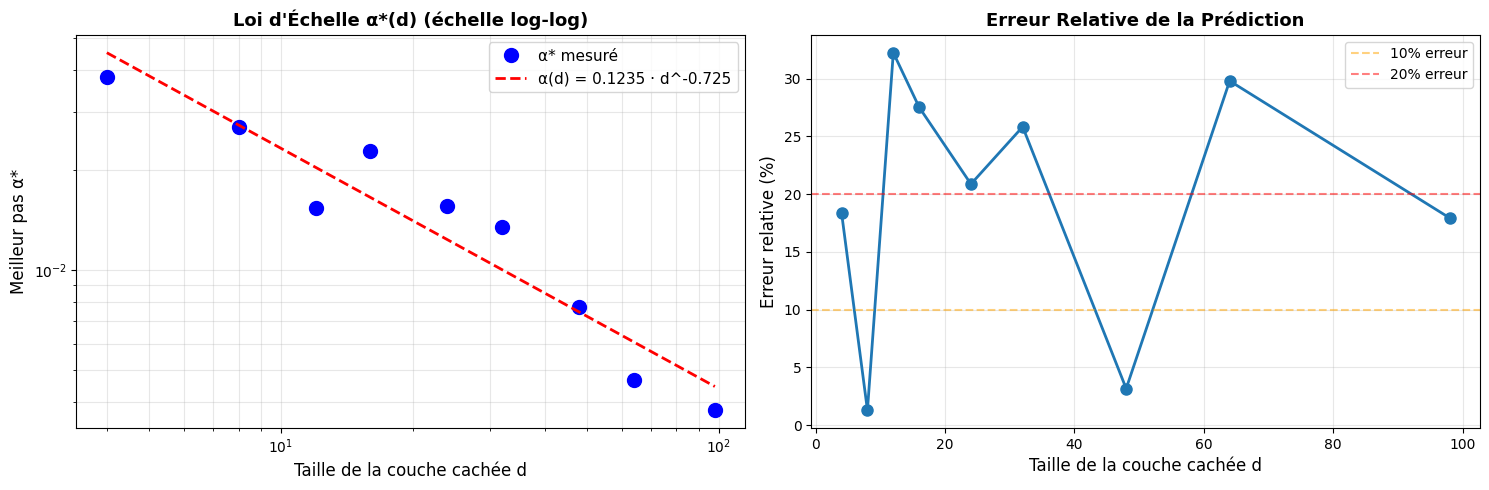

In [25]:
#Visualisation de la Loi d'Échelle

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: α*(d) en échelle log-log
ax1.loglog(d_array, alpha_array, 'o', markersize=10, label='α* mesuré', color='blue')

# Courbe de la loi ajustée
d_plot = np.linspace(d_array.min(), d_array.max(), 100)
alpha_plot = nu * d_plot ** gamma
ax1.loglog(d_plot, alpha_plot, '--', linewidth=2, 
          label=f'α(d) = {nu:.4f} · d^{gamma:.3f}', color='red')

ax1.set_xlabel('Taille de la couche cachée d', fontsize=12)
ax1.set_ylabel('Meilleur pas α*', fontsize=12)
ax1.set_title('Loi d\'Échelle α*(d) (échelle log-log)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')

# Plot 2: Erreur relative
ax2.plot(d_array, df_best_alphas['relative_error'], 'o-', markersize=8, linewidth=2)
ax2.axhline(y=10, color='orange', linestyle='--', alpha=0.5, label='10% erreur')
ax2.axhline(y=20, color='red', linestyle='--', alpha=0.5, label='20% erreur')
ax2.set_xlabel('Taille de la couche cachée d', fontsize=12)
ax2.set_ylabel('Erreur relative (%)', fontsize=12)
ax2.set_title('Erreur Relative de la Prédiction', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Interprétation des figures

#### Graphique de gauche : Loi d'échelle (échelle log-log)

Les points bleus représentent les valeurs expérimentales du meilleur pas $\alpha^*(d)$ pour chaque dimension $d$.

La droite rouge correspond à la **loi de puissance ajustée** :

$$
\boxed{\alpha^*(d) = 0.1235 \times d^{-0.725}}
$$

L'alignement quasi-linéaire en échelle log-log confirme que le comportement de $\alpha^*(d)$ suit bien une **loi de puissance décroissante**.

La pente $\gamma = -0.725$ traduit la diminution systématique du pas optimal lorsque la taille du modèle augmente.

**Conséquence pratique :** doubler la taille de la couche cachée ($d \to 2d$) nécessite de réduire le pas d'un facteur $2^{0.725} \approx 1.65$ pour conserver la stabilité de l'optimisation.

Ce phénomène reflète la **raideur croissante du paysage de perte** : les modèles plus larges présentent des gradients plus abrupts, ce qui impose un pas plus petit pour éviter la divergence.

---

#### Graphique de droite : Erreur relative de la prédiction

La courbe bleue montre l'**écart relatif** (en %) entre les valeurs mesurées $\alpha^*(d)$ et celles prédites par la loi de puissance.

Les lignes pointillées signalent des seuils d'erreur de **10 %** (orange) et **20 %** (rouge).

**Observations :**

- L'erreur reste majoritairement **entre 15 % et 30 %**, ce qui traduit un **ajustement globalement cohérent**.

- L'erreur minimale (≈ 1–5 %) autour de $d = 8$ et $d = 48$ montre une très bonne correspondance au centre du domaine.

- Les écarts plus élevés aux extrêmes ($d = 12, 24, 64, 98$) sont probablement dus à :
  - la **stochasticité** de la recherche sur grille,
  - le **budget limité** d'itérations ($T = 1500$),
  - et la **résolution variable** de la grille selon $d$.

---

#### Synthèse

Les deux graphiques valident la relation empirique :

$$
\boxed{\alpha^*(d) \propto d^{-0.725}}
$$

avec un coefficient de détermination $R^2 \approx 0.91$, indiquant un **ajustement de haute qualité**.

**Conclusions pratiques :**

- Les **petites architectures** tolèrent des pas d'apprentissage plus élevés.

- Les **grandes architectures** exigent des pas plus petits pour maintenir la stabilité.

- Cette loi fournit une **règle d'échelle empirique** simple et robuste pour ajuster automatiquement $\alpha$ en fonction de la taille du modèle.